In [11]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot


In [2]:
!pip install keras

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
##loading the image

In [4]:
from PIL import Image
rel_dir = "/storage/"
#rel_dir = ""

In [5]:
cnn_base = VGG16(input_shape=(224,224,3),include_top=True,weights='imagenet')
# We'll extract features at the final pool layer.
model = Model(
    inputs=cnn_base.input,
    outputs=cnn_base.get_layer('fc1').output
)
def extract_image(image_path,model):
        img = image.load_img(image_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        return x
def vgg_model(x):
    features = model.predict(x)
    return features

In [6]:
datagen = ImageDataGenerator(rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [25]:
labels = []
image_features = []

labels_test = []
image_features_test = []

for idx,label in enumerate(os.listdir(rel_dir+"/split_images")):
    listdir = np.array(sorted(os.listdir(rel_dir+"/split_images/"+label),key=lambda x: int(x.split(".")[0])))
    print(label,len(listdir))
    batch_sz = 100
    features = []
    labs = []
    label_batches = []
    for file in listdir:
        features.append(np.array(extract_image(rel_dir+"/split_images/"+label+'/'+file,model))[0])
    temp_features = np.array(features)
    print(temp_features.shape)
    print("Done processing features")
    for i in range(int(len(listdir)/batch_sz)):
        for X_batch in datagen.flow(temp_features[i*batch_sz:i*batch_sz+batch_sz],batch_size=5*batch_sz):
                for aug_image in X_batch:
                    transformed_features = vgg_model(np.expand_dims(aug_image, axis=0))
                    label_batches.append(transformed_features)
                    labs.append(label)
                break
    X_train,X_test,y_train,y_test = train_test_split(label_batches,labs,shuffle=False,test_size=0.3)
    image_features = image_features + X_train
    labels = labels + y_train
    
    labels_test = labels_test + y_test
    image_features_test = image_features_test + X_test

Aug 11th Decaying Ice 2439
(2439, 224, 224, 3)
Done processing features
Sept 5th Helicopter 1490
(1490, 224, 224, 3)
Done processing features
Aug 28th Stopped Ram Ice 2979
(2979, 224, 224, 3)
Done processing features
Aug 15th Ice Under Pressure 1265
(1265, 224, 224, 3)
Done processing features
Discoloured Ice 676
(676, 224, 224, 3)
Done processing features
Aug 16th-17th Helicopter 1309
(1309, 224, 224, 3)
Done processing features
Aug 20th-26th 1213
(1213, 224, 224, 3)
Done processing features
Aug 14th Decaying 1106
(1106, 224, 224, 3)
Done processing features
Sept 8th Swell 1862
(1862, 224, 224, 3)
Done processing features
Aug 29th-30th 3536
(3536, 224, 224, 3)
Done processing features
Aug 10th Decaying Ice Stopped Luis 2279
(2279, 224, 224, 3)
Done processing features


In [24]:
!rm -rf augmented_saved_images
!mkdir augmented_saved_images
i=3
for X_batch in datagen.flow(temp_features[i*batch_sz:i*batch_sz+batch_sz],batch_size=32,save_to_dir='augmented_saved_images'):
    break

In [28]:
num_labels = len(np.unique(labels))

In [29]:
image_f = np.squeeze(np.array(image_features),axis=1)
image_f_test = np.squeeze(np.array(image_features_test),axis=1)

In [30]:
num_of_train_examples = image_f.shape
print(num_of_train_examples)

(13720, 4096)


In [31]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [32]:
le.fit(list(labels)+list(labels_test))
le_labels = le.transform(labels)
le_labels_test = le.transform(labels_test)
one = preprocessing.OneHotEncoder()
one.fit(list(le_labels.reshape(-1,1))+list(le_labels_test.reshape(-1,1)))
one_labels = one.transform(le_labels.reshape(-1,1))
one_labels_test = one.transform(le_labels_test.reshape(-1,1))

In [33]:
image_input = Input(shape=(4096,))
output = Dense(num_labels,activation='softmax')(image_input)
model_dense = Model(image_input, output)
model_dense.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
model_dense.save_weights('vgg-model.h5')

In [34]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,shuffle=True)
validation_cvscores = []
test_cvscores = []
epochs = 1
for train, test in kf.split(image_f):
    model_dense.load_weights('vgg-model.h5')
    hist = model_dense.fit(image_f[train], one_labels[train], epochs=5, verbose=1)
    print(hist.history)
    val_score = model_dense.evaluate(image_f[test], one_labels[test], verbose=0)
    test_score = model_dense.evaluate(image_f_test, one_labels_test, verbose=0)
    validation_cvscores.append(val_score)
    test_cvscores.append(test_score)

Epoch 1/5
12348/12348 [==============================] - 1s 97us/step - loss: 0.7881 - acc: 0.9102
Epoch 2/5
12348/12348 [==============================] - 1s 93us/step - loss: 0.2474 - acc: 0.9810
Epoch 3/5
12348/12348 [==============================] - 1s 94us/step - loss: 0.0128 - acc: 0.9977
Epoch 4/5
12348/12348 [==============================] - 1s 92us/step - loss: 0.0055 - acc: 0.9993
Epoch 5/5
12348/12348 [==============================] - 1s 91us/step - loss: 0.0046 - acc: 0.9996
{'acc': [0.9101878846776806, 0.9809685779073534, 0.9977324263038548, 0.999271137026239, 0.9995950761256883], 'loss': [0.7881369098016532, 0.247432553087072, 0.012840025611097237, 0.0055329990359261555, 0.00456705664709509]}
Epoch 1/5
12348/12348 [==============================] - 1s 94us/step - loss: 0.2866 - acc: 0.9374
Epoch 2/5
12348/12348 [==============================] - 1s 94us/step - loss: 0.0123 - acc: 0.9966
Epoch 3/5
12348/12348 [==============================] - 1s 94us/step - loss: 0.004

In [35]:
print(np.mean(np.array(validation_cvscores)[:,1]))
print(np.std(np.array(validation_cvscores)[:,1]))
print(np.mean(np.array(test_cvscores)[:,1]))
print(np.std(np.array(test_cvscores)[:,1]))

0.9977405248160961
0.0012812242076994343
0.7571088435374149
0.01874359532429587


In [42]:
 np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
print(np.array(validation_cvscores)[:,1]*100)
print(np.array(test_cvscores)[:,1]*100)

[99.71 99.85 99.78 99.78 99.93 99.85 99.78 99.49 99.93 99.64]
[75.68 80.24 74.56 74.66 74.51 75.36 73.45 77.45 76.72 74.49]


In [28]:
print("Validation Standard Deviation",np.std(validation_cvscores))
print("Test Standard Deviation",np.std(test_cvscores))

Validation Standard Deviation 5.317274113929071
Test Standard Deviation 4.511110109877154


Text(0,0.5,'Categorial Cross Entropy')

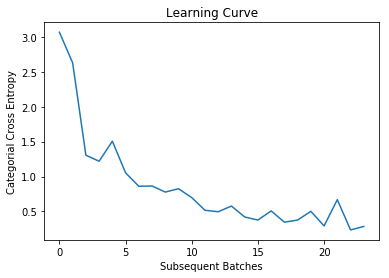

In [31]:
plt.plot(np.arange(epochs*num_of_batches),loss_values)
plt.title("Learning Curve")
plt.xlabel('Subsequent Batches')
plt.ylabel('Categorial Cross Entropy')

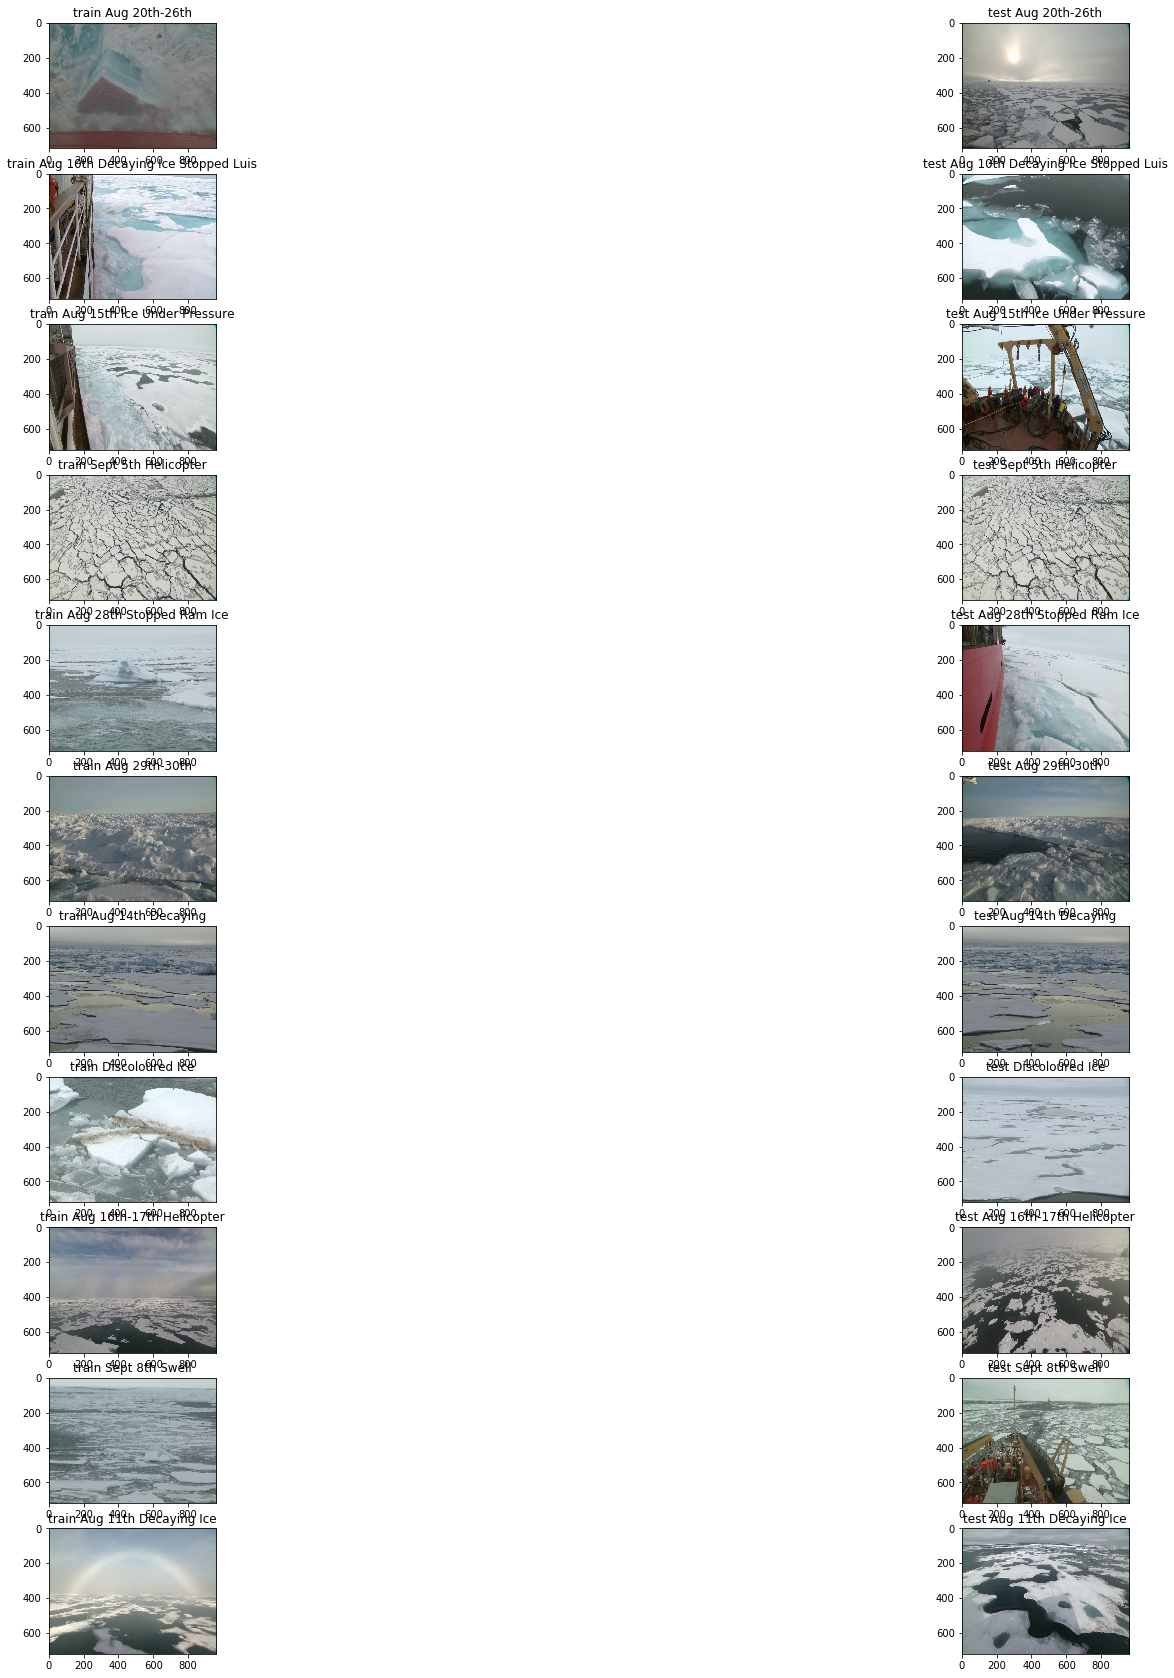

In [32]:
f, axarr = plt.subplots(num_labels,2)
f.set_figheight(30)
f.set_figwidth(30)
for i in range(num_labels):
    axarr[i,0].imshow(mpimg.imread(images_to_show[i][0]))
    axarr[i,0].title.set_text("train "+images_to_show[i][2])
    axarr[i,1].imshow(mpimg.imread(images_to_show[i][1]))
    axarr[i,1].title.set_text("test "+images_to_show[i][2])
plt.show()
plt.savefig('transferlearning.png')
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# image = mpimg.imread(images[0])
# plt.imshow(image)
# plt.show()